## 说明
该notebook用来展示和说明模型权重初始化的重要性，尝试展示了使用更合理的模型初始化方法，对模型训练的影响。

In [1]:
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
import math
from functools import partial


In [2]:
def outs_hist(outs, bins=20, rm_zeros=False):
    """绘制每层输出的直方图"""
    outs = [x.flatten() for x in outs]
    if rm_zeros:
        outs = [[x for x in xs if x > 0] for xs in outs]
    fig, axs = plt.subplots(5, 2, figsize=(24, 12))
    k = 0
    for i in range(5):
        for j in range(2):
            axs[i][j].hist(outs[k], bins=bins)
            axs[i][j].set_title('out-{}'.format(k))
            k += 1
    plt.tight_layout()
    plt.show()


def weight_hist(m):
    """绘制每层权重的直方图"""
    ws = [w.weight.detach().numpy().flatten() for w in m.layers]
    fig, axs = plt.subplots(5, 2, figsize=(12, 12))
    k = 0
    for i in range(5):
        for j in range(2):
            axs[i][j].hist(ws[k], bins=50)
            axs[i][j].set_title("w-{}".format(k))
            k += 1
    plt.tight_layout()
    plt.show()

In [3]:
class Model(nn.Module):
    """N X [线性层+激活层]"""
    def __init__(self, n, activate):
        super().__init__()
        self.activate = activate
        self.layers = nn.ModuleList([nn.Linear(64, 64) for _ in range(n)])
        self.outs = []

    def forward(self, x):
        """X: shape [N, 64]"""
        self.outs = [x]
        for m in self.layers:
            x = m(x)
            if self.activate == 'relu': 
                x = nn.functional.relu(x)
            elif self.activate == 'tanh':
                x = nn.functional.tanh(x)
            else:
                x = nn.functional.sigmoid(x)
            self.outs.append(x.detach().numpy())
        return x

In [4]:
@torch.no_grad()
def normal_init(m, sigma=1.0):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, 0.0, sigma)

In [5]:
@torch.no_grad()
def uniform_init(m, r):
    if type(m) == nn.Linear:
        nn.init.uniform_(m.weight, -r, r)

In [6]:
x = torch.randn(100, 64)

使用均值为0、方差为1的高斯分布初始化模型的权重，可以发现，每层的输出集中在了0，和1.0附近，信号在网络中没有很好的传递，导致无法训练。

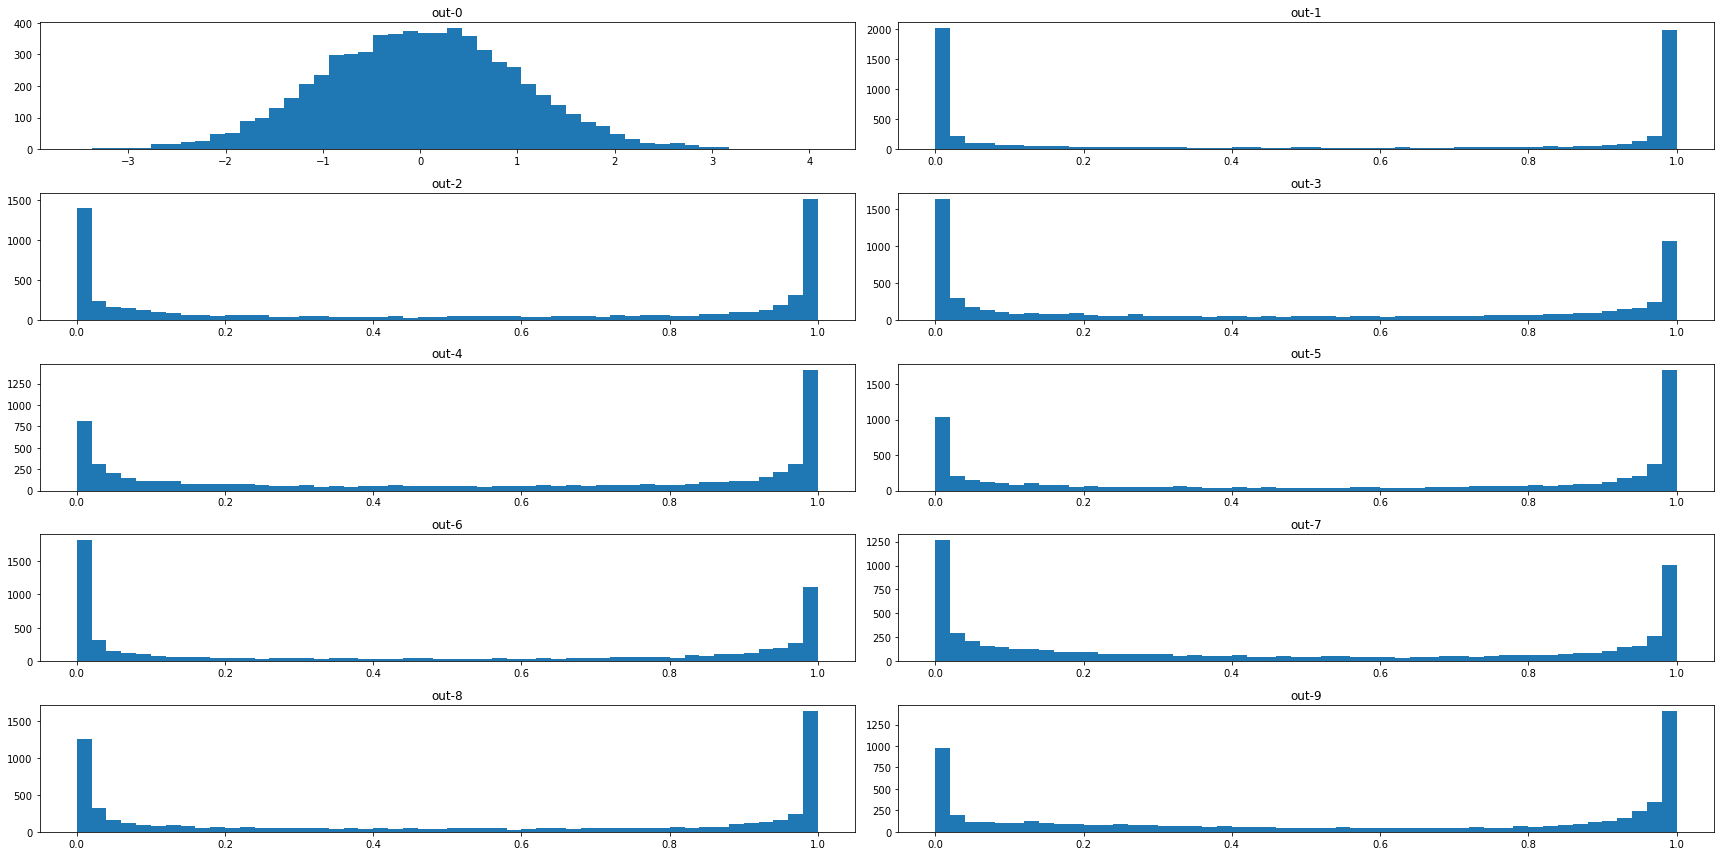

In [7]:
model_sigmoid = Model(10, 'sigmoid')
model_sigmoid.apply(partial(normal_init, sigma=1.0))
model_sigmoid(x)
outs_hist(model_sigmoid.outs, bins=50)   

使用XaVier初始化，对于sigmoid的激活函数，使用均值为0，标准差$\sigma = 4 \sqrt \frac {2}{n_{in} + n_{out}}$的高斯分布，初始化权重，可以看到，每层的输出的分布更加丰富，有利于网络的训练。

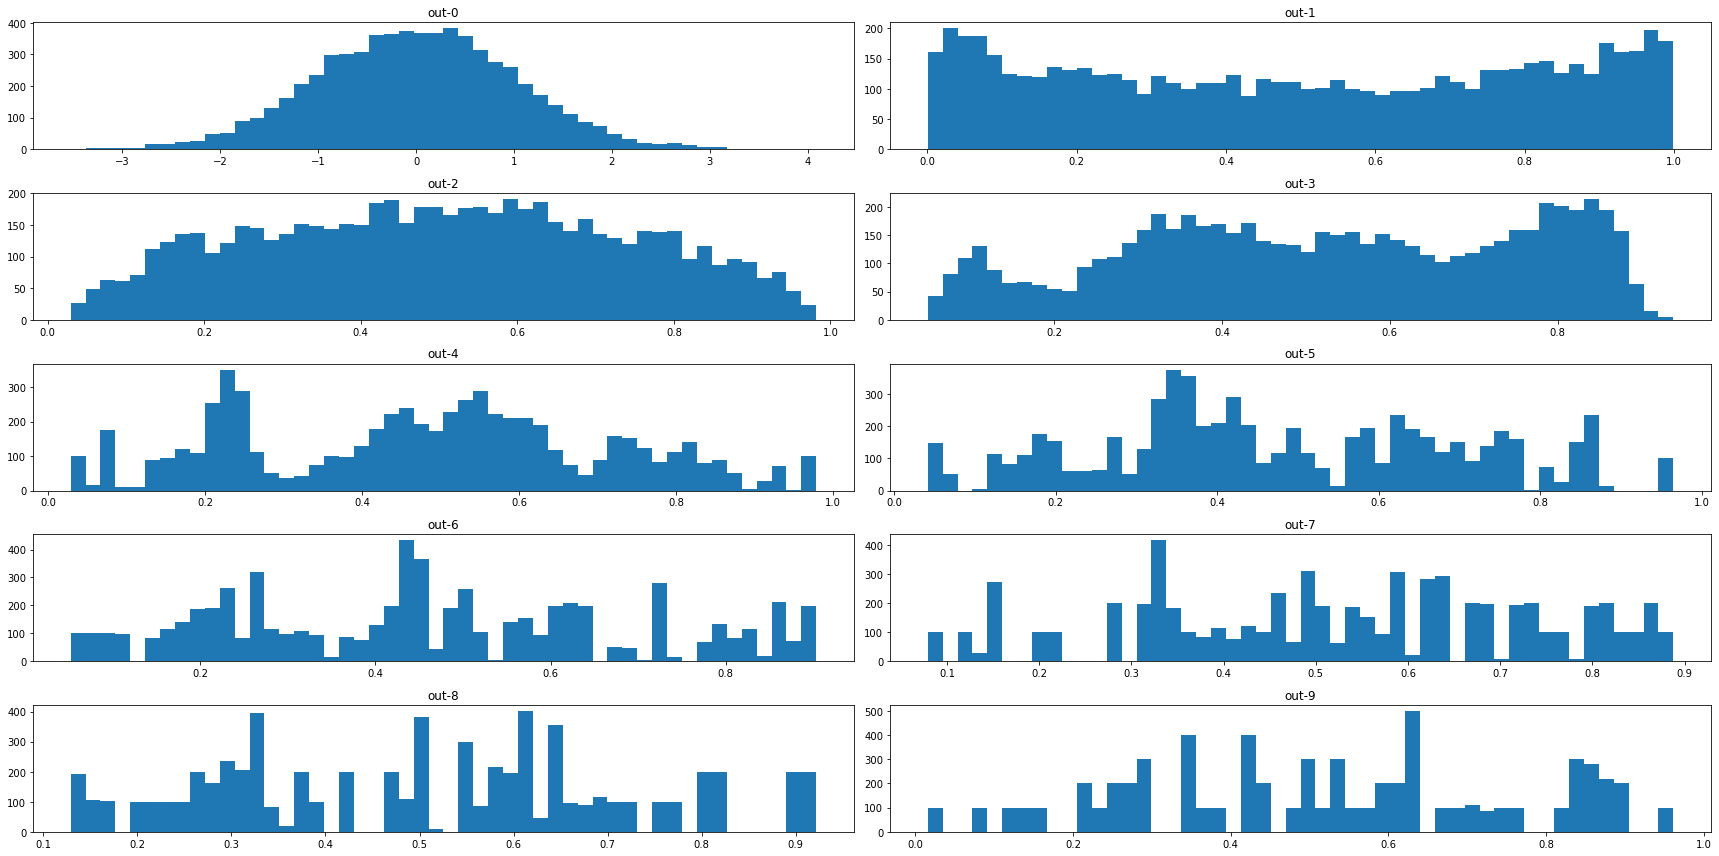

In [8]:
model_sigmoid = Model(10, 'sigmoid')
model_sigmoid.apply(partial(normal_init, sigma=32 / (64 + 64)))
model_sigmoid(x)
outs_hist(model_sigmoid.outs, bins=50)   

同样，也可以看到使用均匀分布的情况，使用$X \sim U(-r, r)$，其中$r = 4 \sqrt \frac{6}{n_{in} + n_{out}} $，初始化权重，也可以做到比较好的效果。

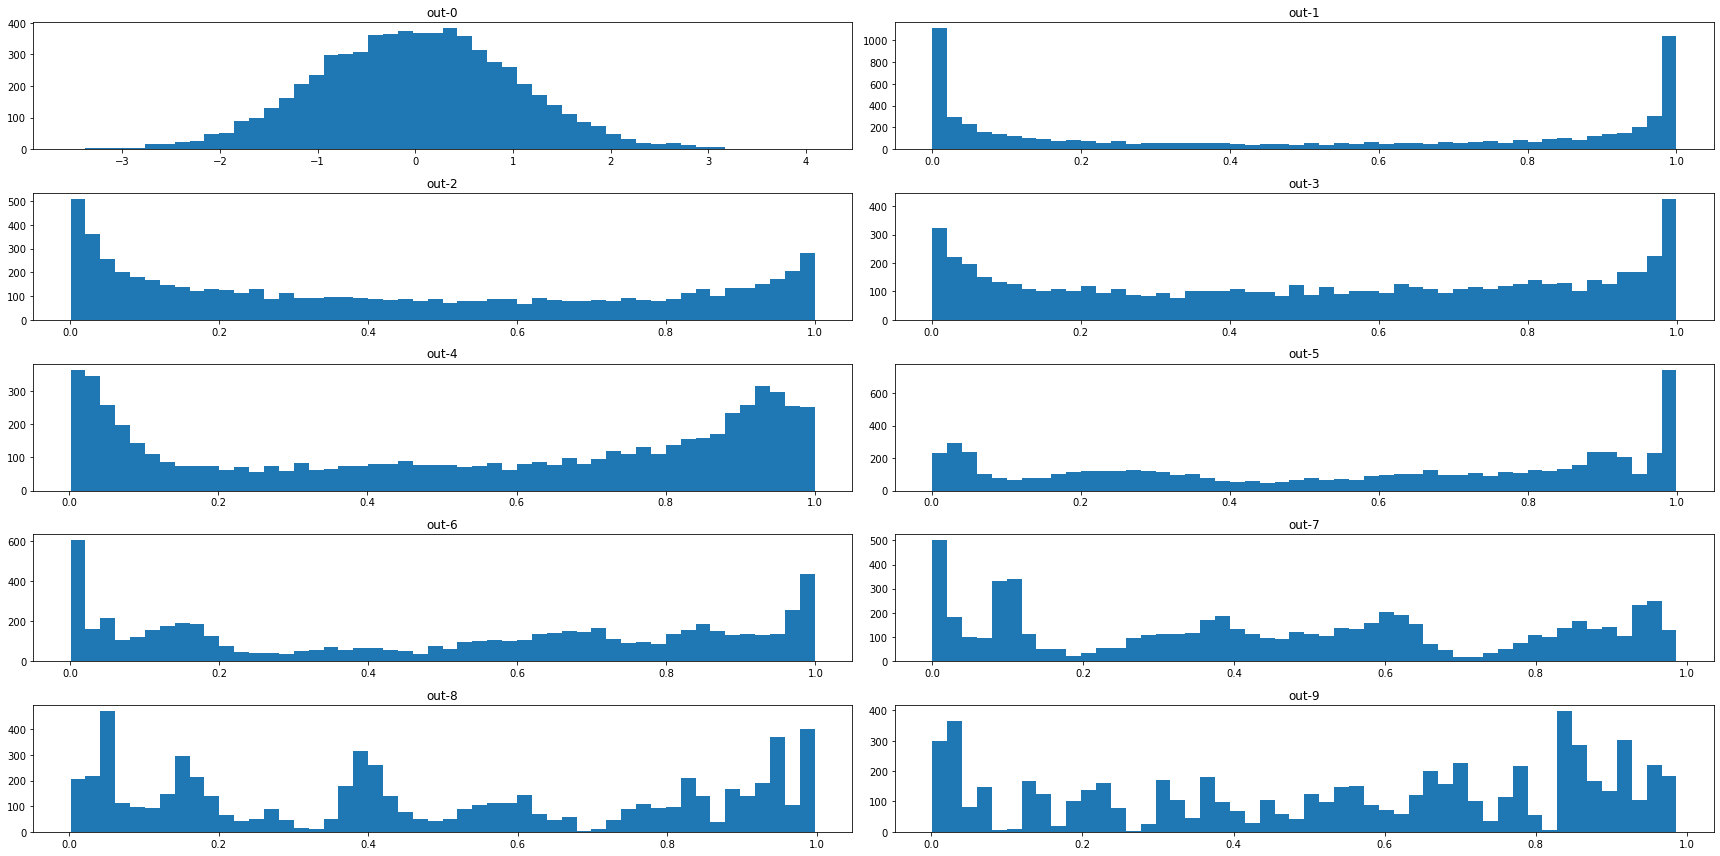

In [9]:
model_sigmoid = Model(10, 'sigmoid')
model_sigmoid.apply(partial(uniform_init, r=4.0 * math.sqrt(6.0 / 2 / 64)))
model_sigmoid(x)
outs_hist(model_sigmoid.outs, bins=50)   

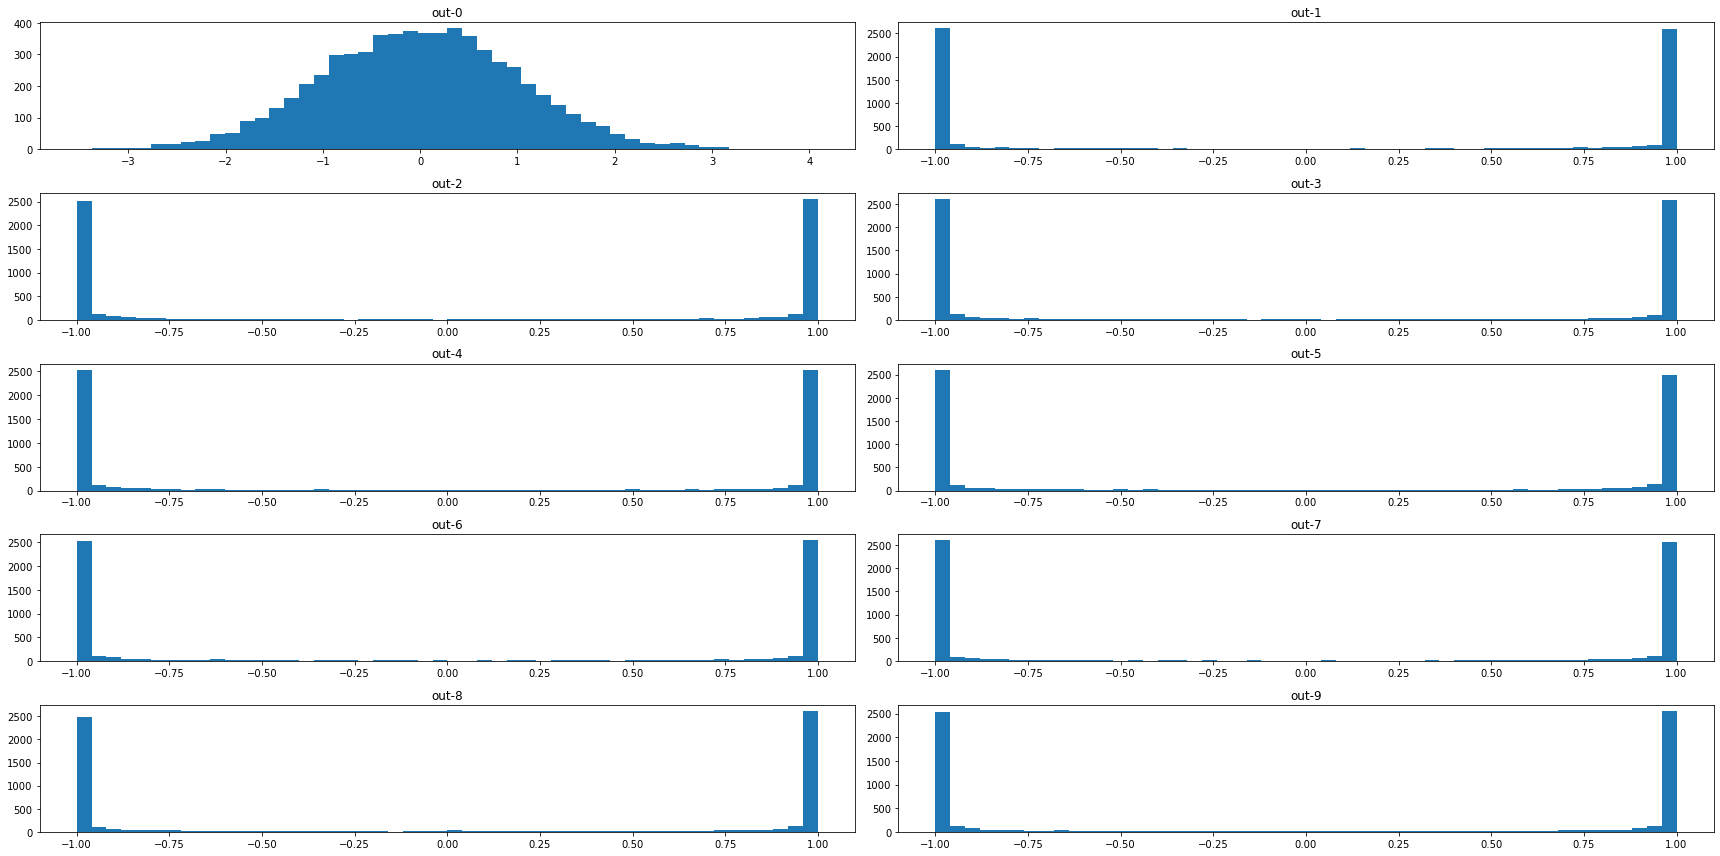

In [10]:
model_tanh = Model(10, 'tanh')
model_tanh.apply(partial(normal_init, sigma=1.0))
model_tanh(x)
outs_hist(model_tanh.outs, bins=50)   

激活函数为tanh时，应使用均值为0，标准差为$\sigma = \sqrt \frac {2} {n_{in} + n_{out}}$高斯分布初始化权重；或者使用$r = \sqrt \frac{6}{n_{in} + n_{out}}$的均匀分布初始化权重。

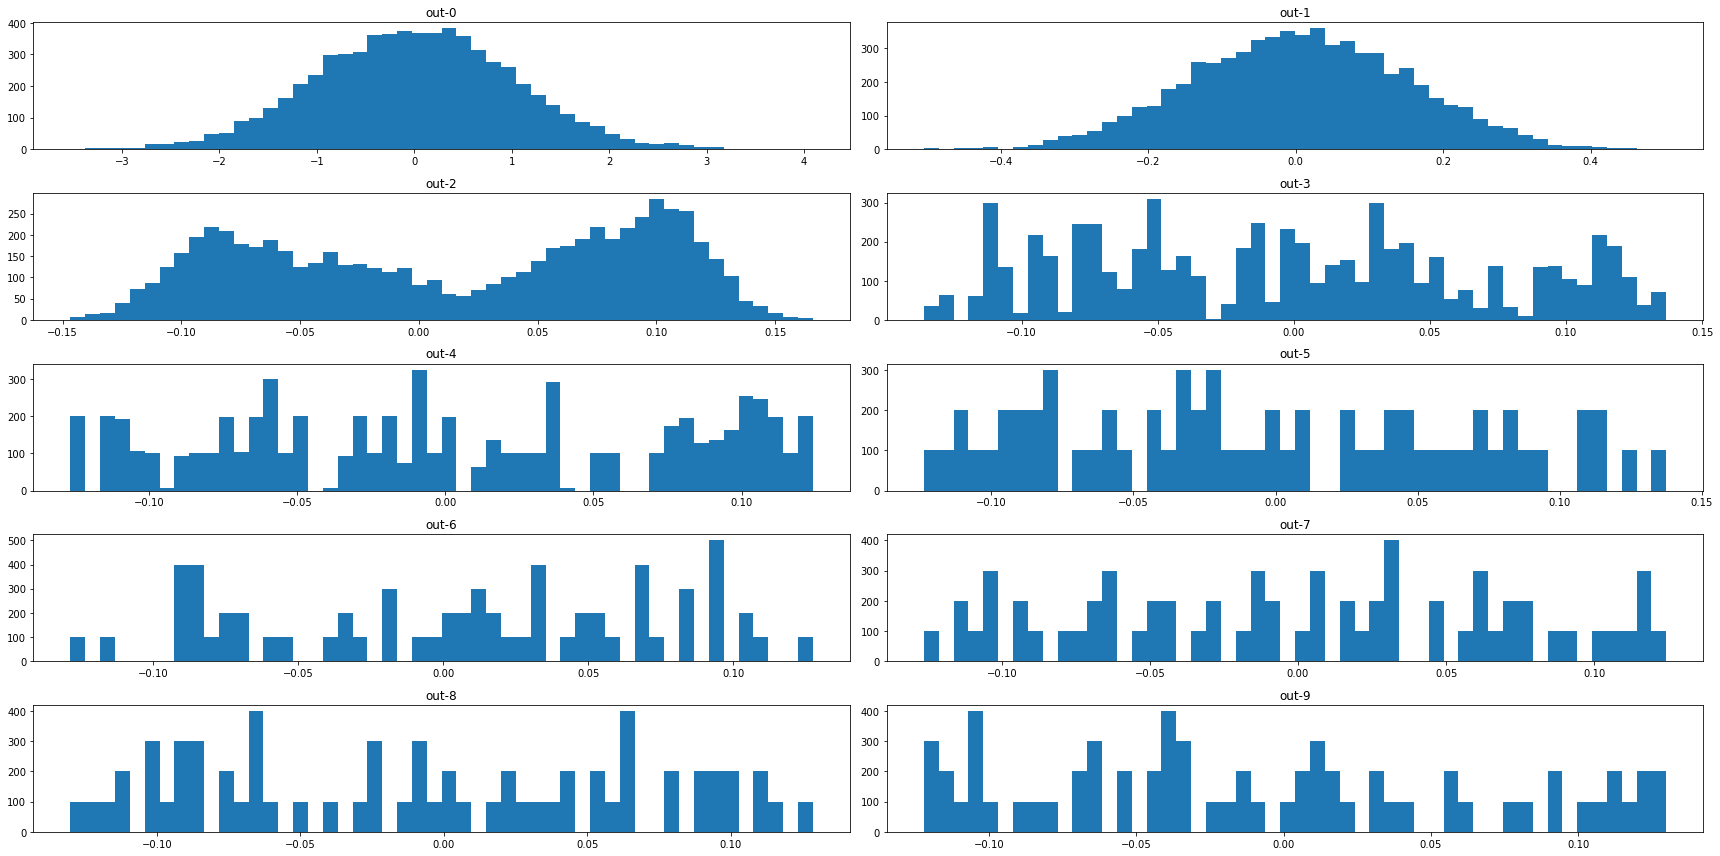

In [11]:
model_tanh = Model(10, 'tanh')
model_tanh.apply(partial(normal_init, sigma=1.0 / 64.0))
model_tanh(x)
outs_hist(model_tanh.outs, bins=50)   

同样的，对于ReLU的激活函数，使用均值为0，标准差$\sigma = \sqrt \frac{4}{n_{in} + n_{out}}$的高斯分布，或者使用$r = \sqrt \frac{12}{n_{in} + n_{out}}$的均匀分布，初始化权重。相比直接使用使用均值为0，标准差1的高斯分布，各层输出的分布情况要好很多。

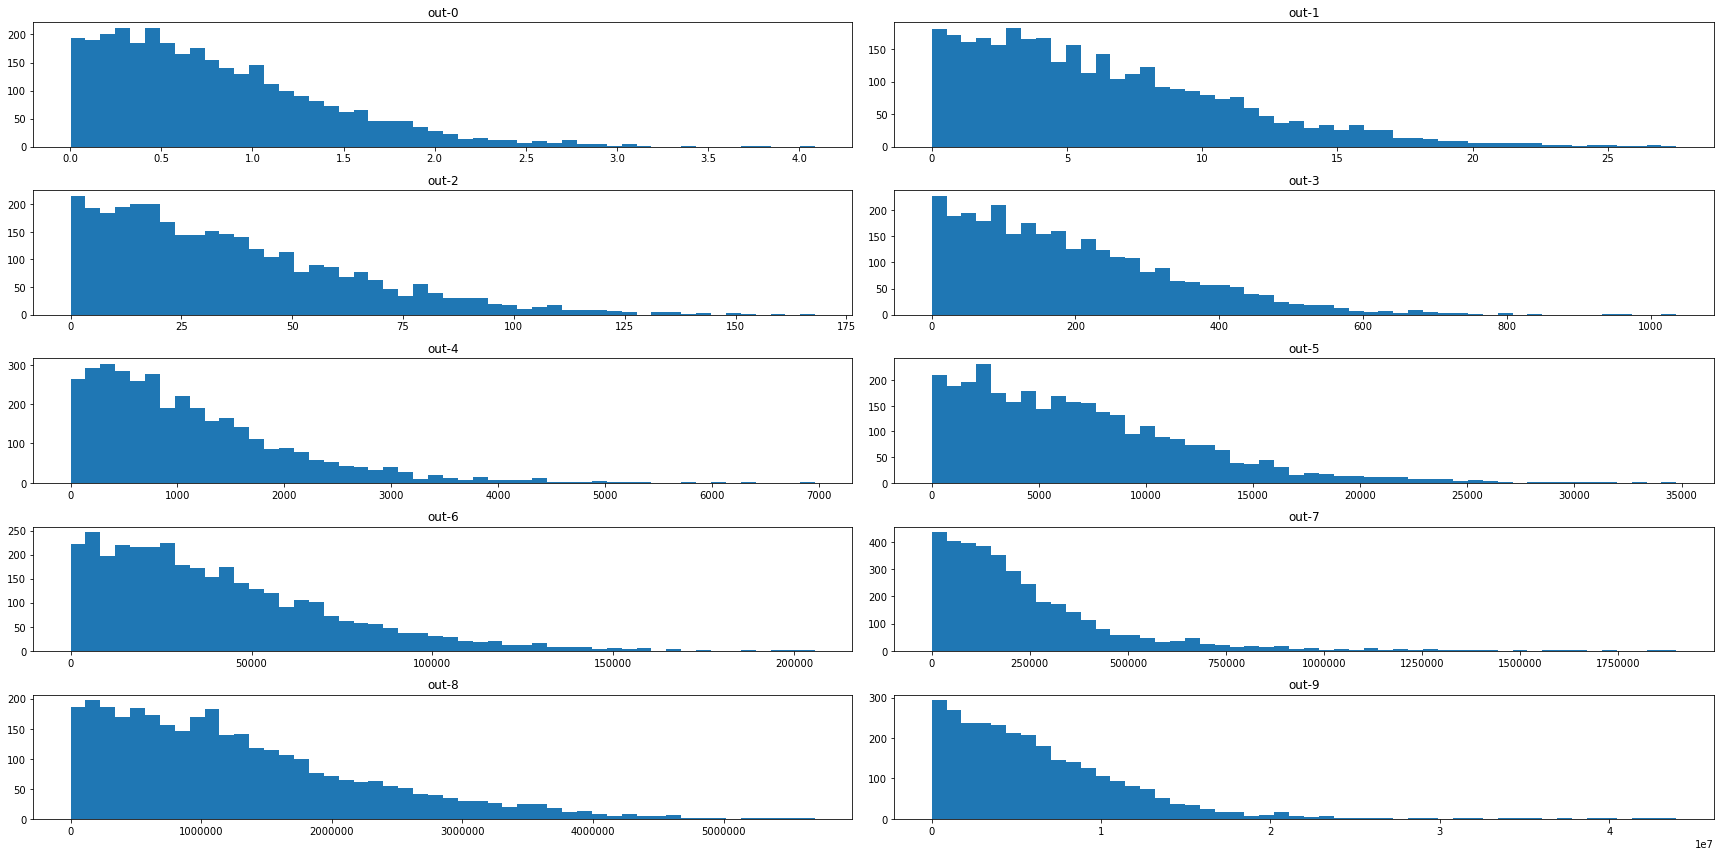

In [12]:
model_relu = Model(10, 'relu')
model_relu.apply(partial(normal_init, sigma=1.0)) 
model_relu(x)
outs_hist(model_relu.outs, bins=50, rm_zeros=True)   

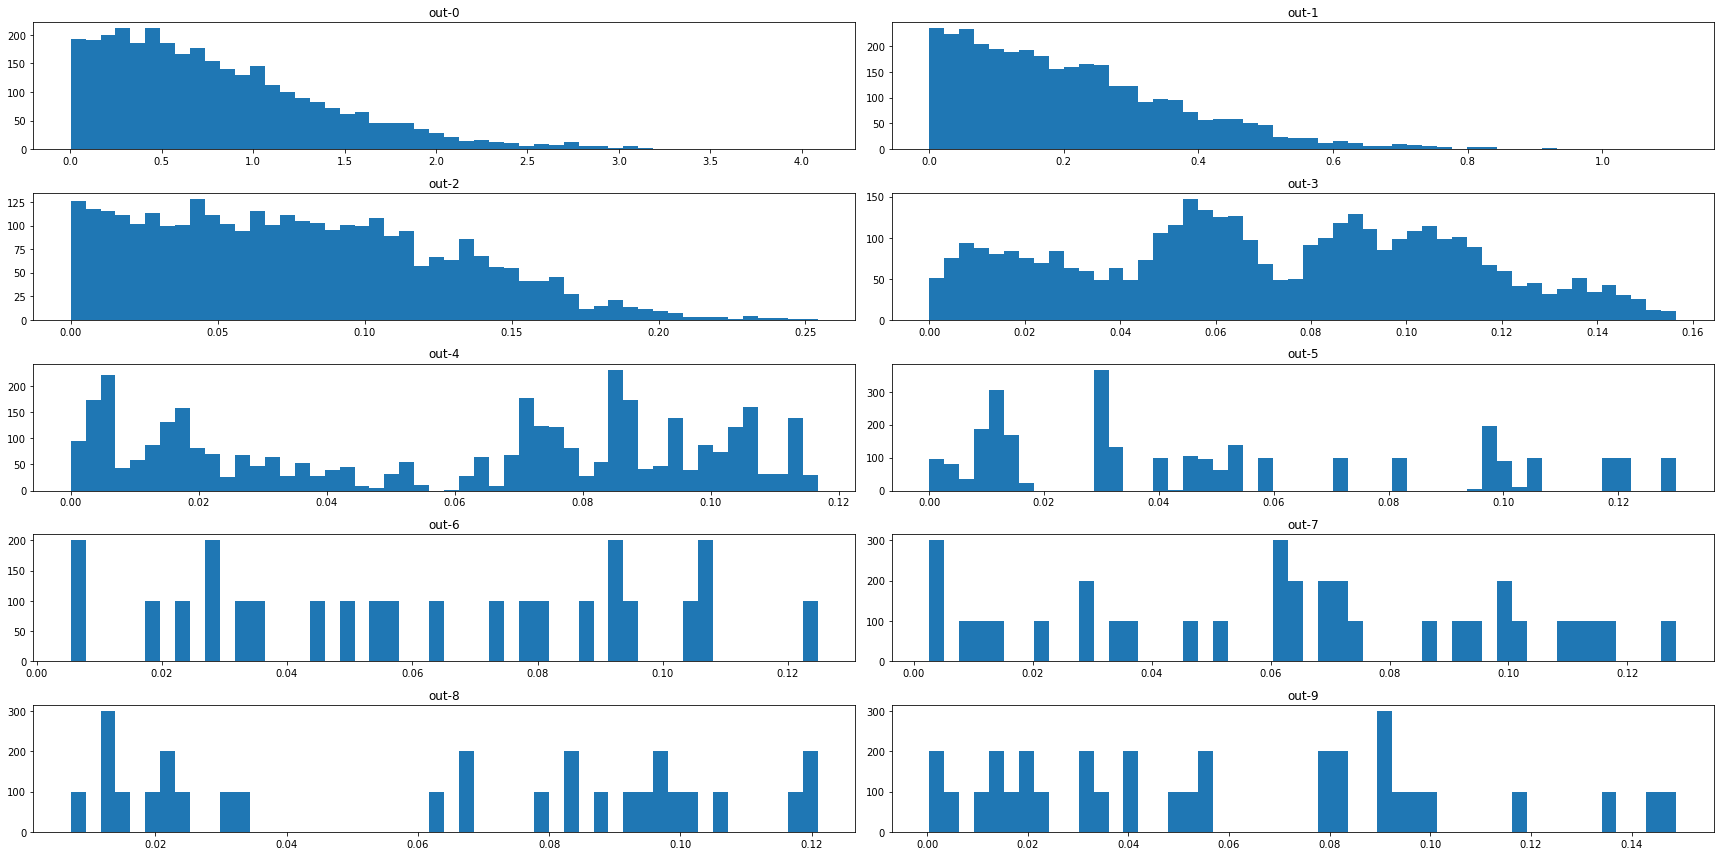

In [13]:
model_relu = Model(10, 'relu')
model_relu.apply(partial(normal_init, sigma=2.0 / 64)) 
model_relu(x)
outs_hist(model_relu.outs, bins=50, rm_zeros=True)   

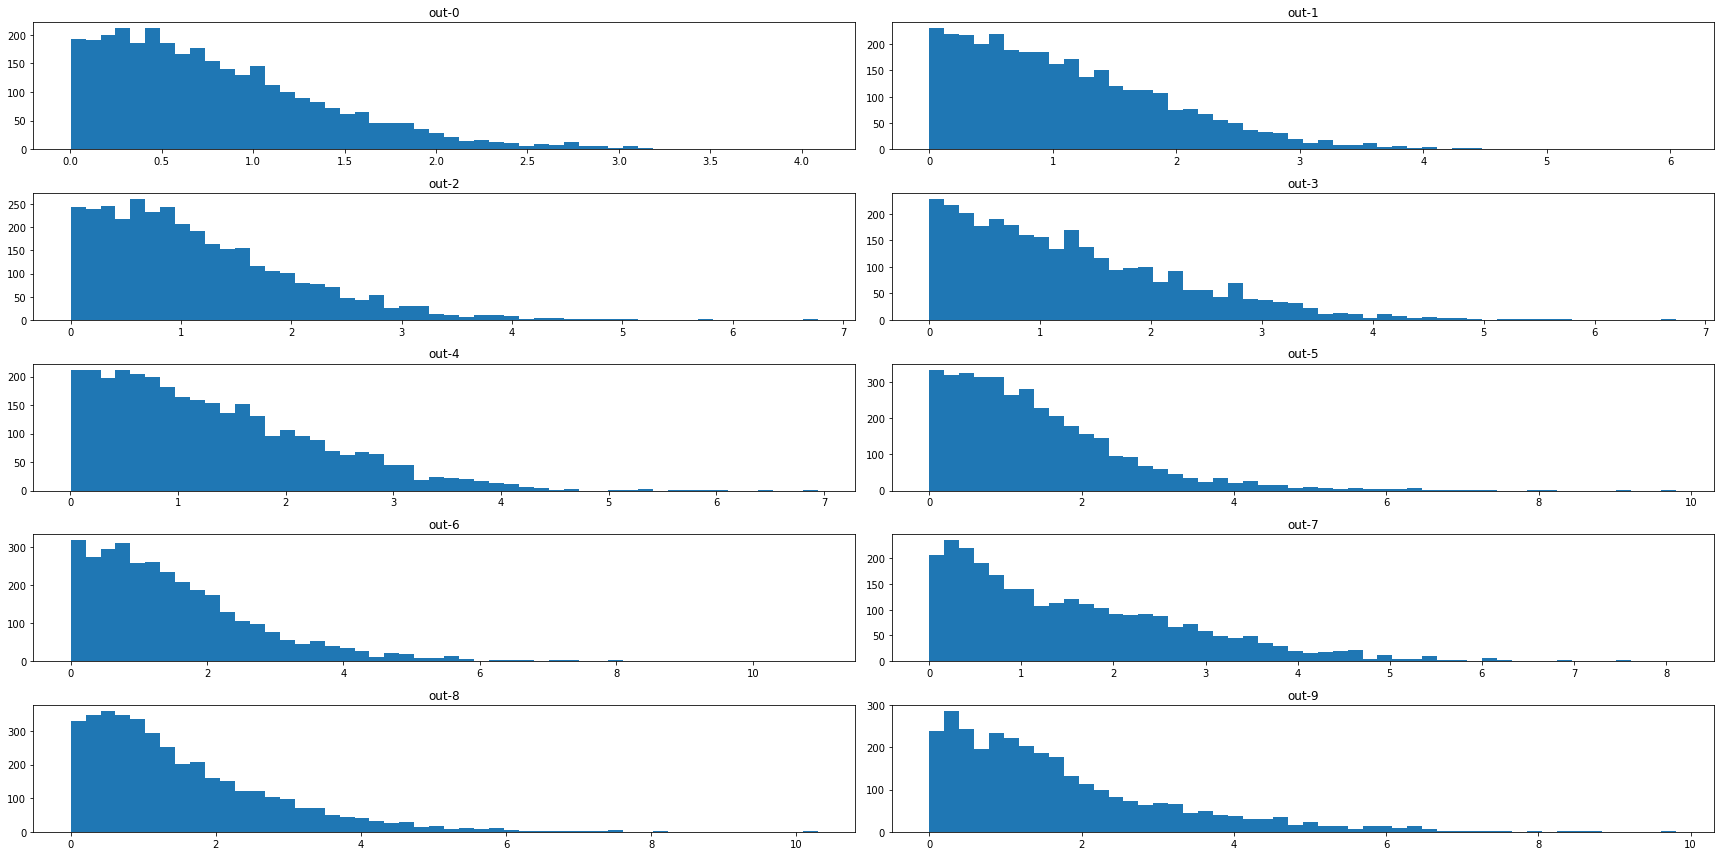

In [14]:
model_relu = Model(10, 'relu')
model_relu.apply(partial(uniform_init, r=math.sqrt(6.0 / 64.0))) 
model_relu(x)
outs_hist(model_relu.outs, bins=50, rm_zeros=True)